Successfully loaded the data
Top 10 handsets:
                        handset  usage_count
0              Huawei B528S-23A        19752
1       Apple iPhone 6S (A1688)         9419
2        Apple iPhone 6 (A1586)         9023
3                     undefined         8987
4        Apple iPhone 7 (A1778)         6326
5       Apple iPhone Se (A1723)         5187
6        Apple iPhone 8 (A1905)         4993
7       Apple iPhone Xr (A2105)         4568
8  Samsung Galaxy S8 (Sm-G950F)         4520
9        Apple iPhone X (A1901)         3813
Top 3 manufacturers:
  manufacturer  usage_count
0        Apple        59565
1      Samsung        40839
2       Huawei        34423
Top 5 handsets for Apple:
                   handset  usage_count
0  Apple iPhone 6S (A1688)         9419
1   Apple iPhone 6 (A1586)         9023
2   Apple iPhone 7 (A1778)         6326
3  Apple iPhone Se (A1723)         5187
4   Apple iPhone 8 (A1905)         4993
Top 5 handsets for Samsung:
                        handset 

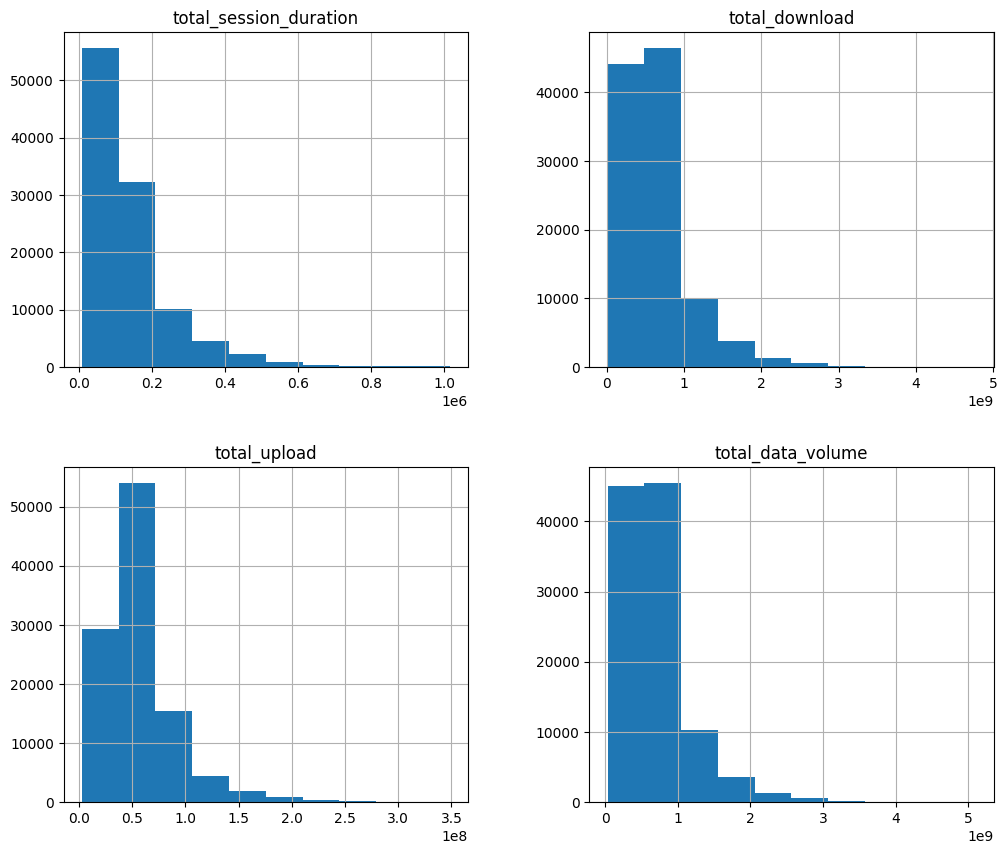

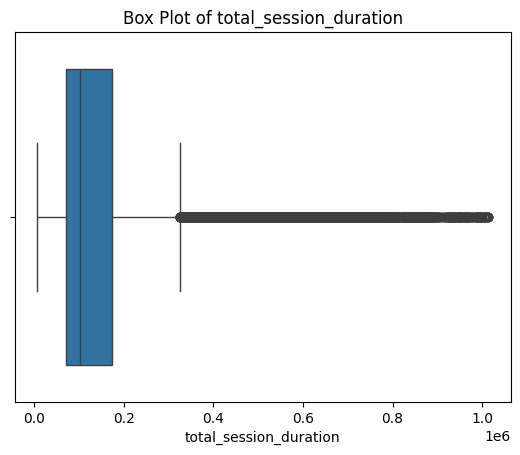

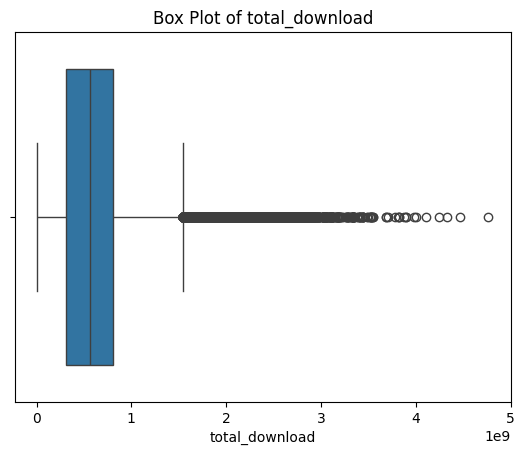

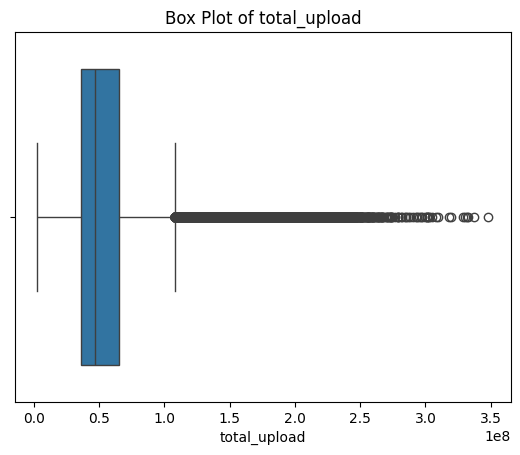

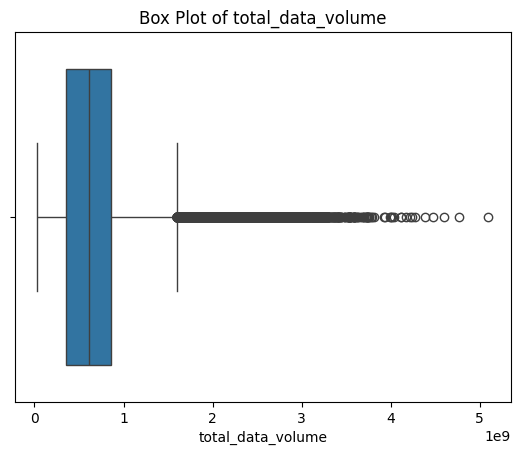

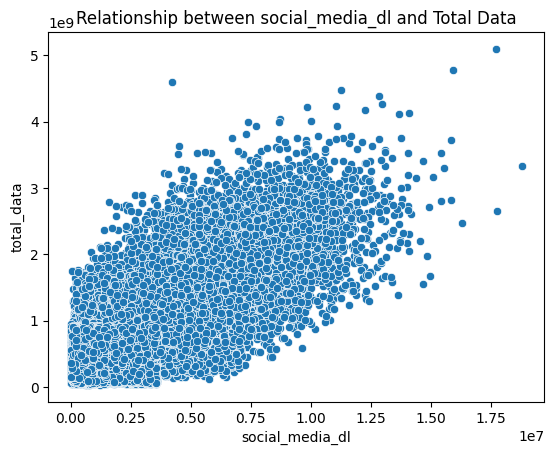

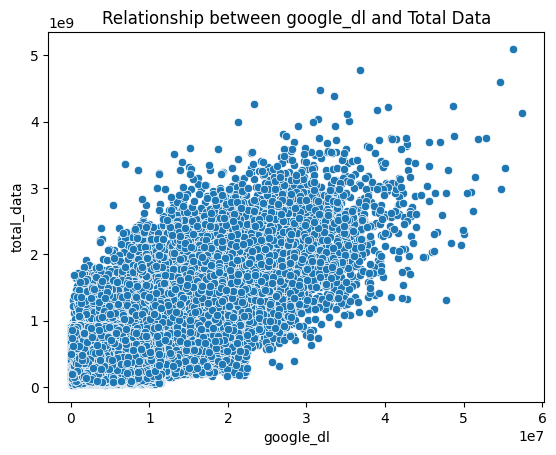

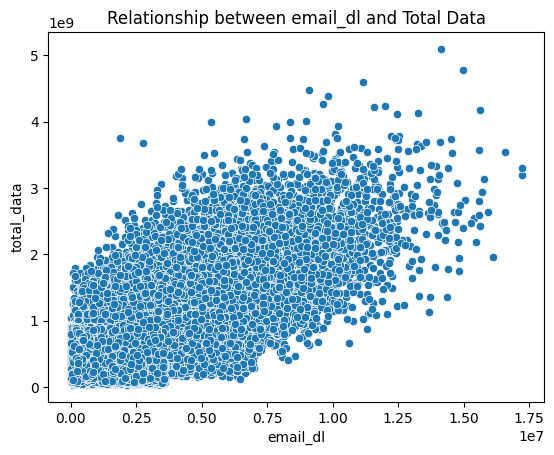

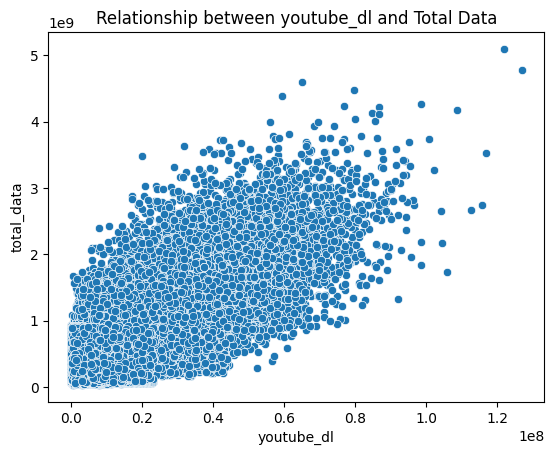

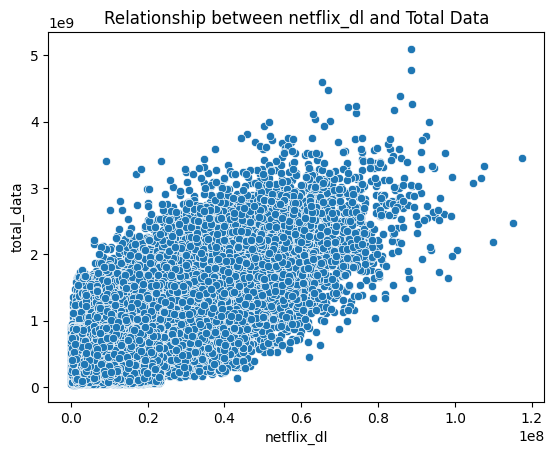

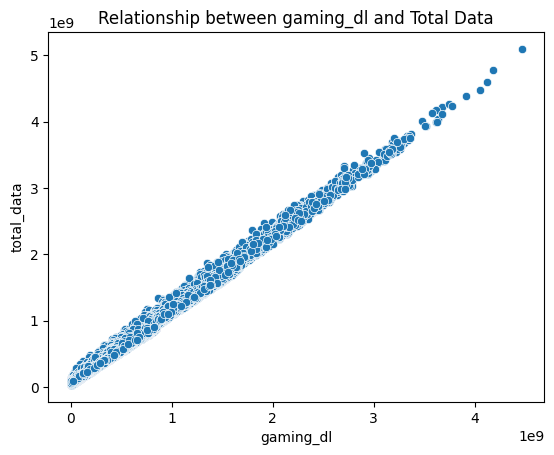

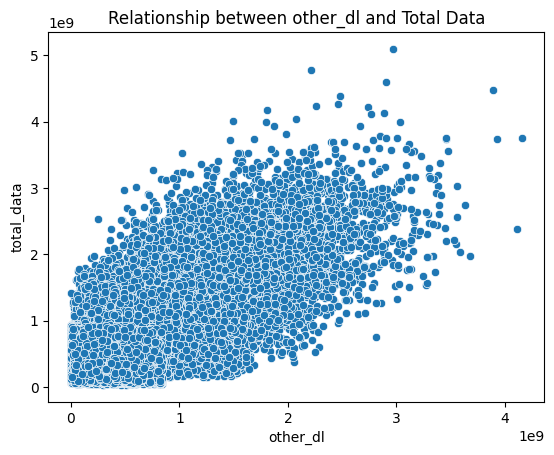

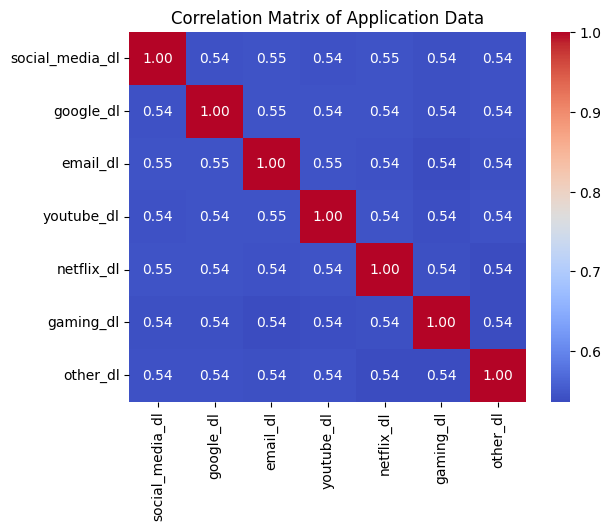

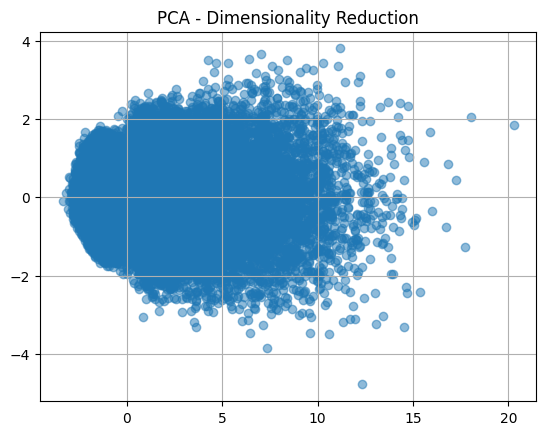

Explained variance by the 2 components: 0.67
Explained variance by the 2 components: [0.60803513 0.06646455]
Total variance explained by the 2 components: 0.67
Principal Component 1 explains 60.80% of the variance
Principal Component 2 explains 6.65% of the variance
Cumulative explained variance by the 2 components: 67.45%
<class 'pandas.core.frame.DataFrame'>
Index: 106348 entries, 0 to 106853
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   user                    106348 non-null  float64
 1   session_count           106348 non-null  int64  
 2   total_session_duration  106348 non-null  float64
 3   total_download          106348 non-null  float64
 4   total_upload            106348 non-null  float64
 5   total_data_volume       106348 non-null  float64
 6   social_media_dl         106348 non-null  float64
 7   social_media_ul         106348 non-null  float64
 8   google_dl               

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import custom function to load data
sys.path.append(os.path.abspath('../scripts'))
from telecom_analysis import load_data_using_sqlalchemy

# Define SQL query to load the main table
query = "SELECT * FROM xdr_data;"

# Load data from PostgreSQL using SQLAlchemy
df = load_data_using_sqlalchemy(query)

if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

# Top 10 Handsets
query_handsets = """
SELECT "Handset Type" AS handset, COUNT(*) AS usage_count
FROM public.xdr_data
GROUP BY "Handset Type"
ORDER BY usage_count DESC
LIMIT 10;
"""
df_handsets = load_data_using_sqlalchemy(query_handsets)

if df_handsets is not None:
    print("Top 10 handsets:")
    print(df_handsets)
else:
    print("Failed to load handsets data.")

# Top 3 Manufacturers
query_manufacturers = """
SELECT "Handset Manufacturer" AS manufacturer, COUNT(*) AS usage_count
FROM public.xdr_data
GROUP BY "Handset Manufacturer"
ORDER BY usage_count DESC
LIMIT 3;
"""
df_manufacturers = load_data_using_sqlalchemy(query_manufacturers)

if df_manufacturers is not None:
    print("Top 3 manufacturers:")
    print(df_manufacturers)
else:
    print("Failed to load manufacturer data.")

# Top 5 Handsets per Manufacturer
if df_manufacturers is not None:
    manufacturers = df_manufacturers['manufacturer'].tolist()
    for manufacturer in manufacturers:
        query_top_handsets = f"""
        SELECT "Handset Type" AS handset, COUNT(*) AS usage_count
        FROM public.xdr_data
        WHERE "Handset Manufacturer" = '{manufacturer}'
        GROUP BY "Handset Type"
        ORDER BY usage_count DESC
        LIMIT 5;
        """
        df_top_handsets = load_data_using_sqlalchemy(query_top_handsets)
        
        if df_top_handsets is not None:
            print(f"Top 5 handsets for {manufacturer}:")
            print(df_top_handsets)
        else:
            print(f"Failed to load data for manufacturer {manufacturer}.")

# User Behavior Analysis Query
query_user_behavior = """
SELECT
    "MSISDN/Number" AS user,
    COUNT(*) AS session_count,
    SUM("Dur. (ms)") AS total_session_duration,
    SUM("Total DL (Bytes)") AS total_download,
    SUM("Total UL (Bytes)") AS total_upload,
    SUM("Total DL (Bytes)") + SUM("Total UL (Bytes)") AS total_data_volume,
    SUM("Social Media DL (Bytes)") AS social_media_dl,
    SUM("Social Media UL (Bytes)") AS social_media_ul,
    SUM("Google DL (Bytes)") AS google_dl,
    SUM("Google UL (Bytes)") AS google_ul,
    SUM("Email DL (Bytes)") AS email_dl,
    SUM("Email UL (Bytes)") AS email_ul,
    SUM("Youtube DL (Bytes)") AS youtube_dl,
    SUM("Youtube UL (Bytes)") AS youtube_ul,
    SUM("Netflix DL (Bytes)") AS netflix_dl,
    SUM("Netflix UL (Bytes)") AS netflix_ul,
    SUM("Gaming DL (Bytes)") AS gaming_dl,
    SUM("Gaming UL (Bytes)") AS gaming_ul,
    SUM("Other DL (Bytes)") AS other_dl,
    SUM("Other UL (Bytes)") AS other_ul
FROM public.xdr_data
GROUP BY "MSISDN/Number";
"""
df_user_behavior = load_data_using_sqlalchemy(query_user_behavior)

if df_user_behavior is not None:
    print("User behavior data loaded:")
    print(df_user_behavior.head())
else:
    print("Failed to load user behavior data.")

# Data Cleaning and Analysis
df_user_behavior.fillna(df_user_behavior.mean(), inplace=True)

# Handle outliers using Z-scores
z_scores = stats.zscore(df_user_behavior.select_dtypes(include=['float64', 'int64']))
df_user_behavior = df_user_behavior[(np.abs(z_scores) < 3).all(axis=1)]

# Segment users into deciles based on total session duration
df_user_behavior['decile'] = pd.qcut(df_user_behavior['total_session_duration'], 10, labels=False) + 1
decile_data = df_user_behavior.groupby('decile')[['total_download', 'total_upload']].sum()
print("Data per decile:")
print(decile_data)

metrics = df_user_behavior[['total_session_duration', 'total_download', 'total_upload', 'total_data_volume']].agg(['mean', 'median', 'std', 'min', 'max'])
print(metrics)
# Data Visualization
df_user_behavior[['total_session_duration', 'total_download', 'total_upload', 'total_data_volume']].hist(figsize=(12, 10))
plt.show()

for column in ['total_session_duration', 'total_download', 'total_upload', 'total_data_volume']:
    sns.boxplot(x=df_user_behavior[column])
    plt.title(f'Box Plot of {column}')
    plt.show()

# Compute total data (DL + UL) for each user
df_user_behavior['total_data'] = df_user_behavior['total_download'] + df_user_behavior['total_upload']

# Scatter plots between apps and total data
application_columns = ['social_media_dl', 'google_dl', 'email_dl', 'youtube_dl', 'netflix_dl', 'gaming_dl', 'other_dl']
for app in application_columns:
    sns.scatterplot(x=df_user_behavior[app], y=df_user_behavior['total_data'])
    plt.title(f'Relationship between {app} and Total Data')
    plt.show()

# Correlation Matrix
correlation_columns = ['social_media_dl', 'google_dl', 'email_dl', 'youtube_dl', 'netflix_dl', 'gaming_dl', 'other_dl']
correlation_matrix = df_user_behavior[correlation_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Application Data')
plt.show()

# PCA for Dimensionality Reduction
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_user_behavior[correlation_columns])
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA - Dimensionality Reduction')
plt.grid(True)
plt.show()

# Explained variance by PCA components
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by the 2 components: {explained_variance.sum():.2f}')
# Explained variance ratio (how much information each component contains)
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by the 2 components: {explained_variance}')

total_explained_variance = explained_variance.sum()
print(f'Total variance explained by the 2 components: {total_explained_variance:.2f}')

# Print the proportion of variance explained by each component
for i, var in enumerate(explained_variance, start=1):
    print(f'Principal Component {i} explains {var:.2%} of the variance')

# Print the cumulative explained variance
cumulative_variance = total_explained_variance
print(f'Cumulative explained variance by the 2 components: {cumulative_variance:.2%}')

print(df_user_behavior.info())
print(df_user_behavior.describe())

Task - 2

Successfully loaded the data


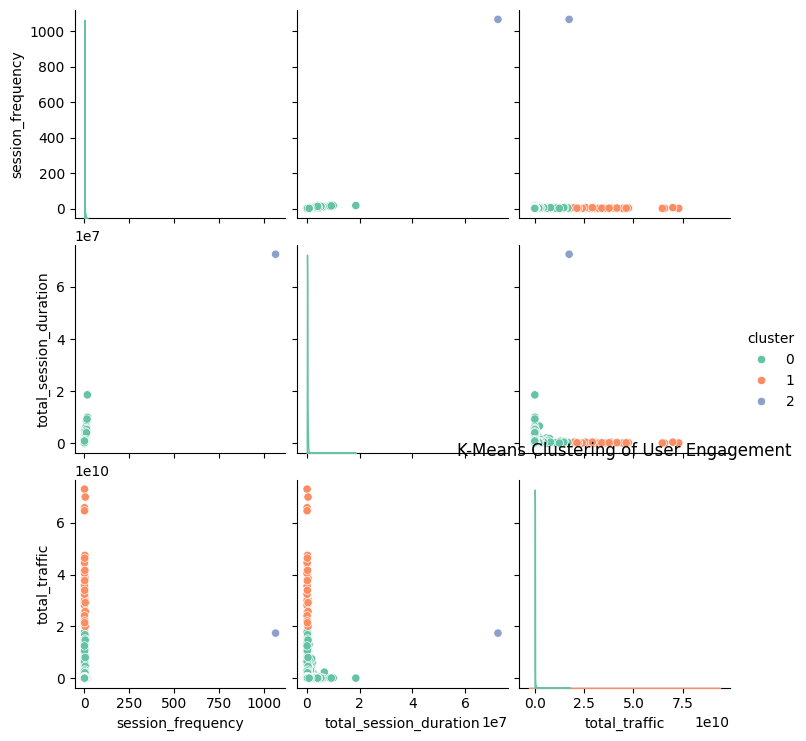

Cluster Summary Statistics:
         session_frequency                            total_session_duration  \
                      min   max         mean     sum                    min   
cluster                                                                       
0                       1    18     1.393469  148849                 7142.0   
1                       1     6     2.324324      86                56123.0   
2                    1066  1066  1066.000000    1066             72446396.0   

                                                total_traffic                \
                max          mean           sum           min           max   
cluster                                                                       
0        18553754.0  1.461471e+05  1.561128e+10  0.000000e+00  1.775945e+10   
1          513104.0  2.041768e+05  7.554541e+06  1.808859e+10  7.302069e+10   
2        72446396.0  7.244640e+07  7.244640e+07  1.739805e+10  1.739805e+10   

                     

C:\Users\Yonas\AppData\Local\Temp\ipykernel_4164\2008698929.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Total Traffic', x='Application', data=top_3_df, palette='viridis')


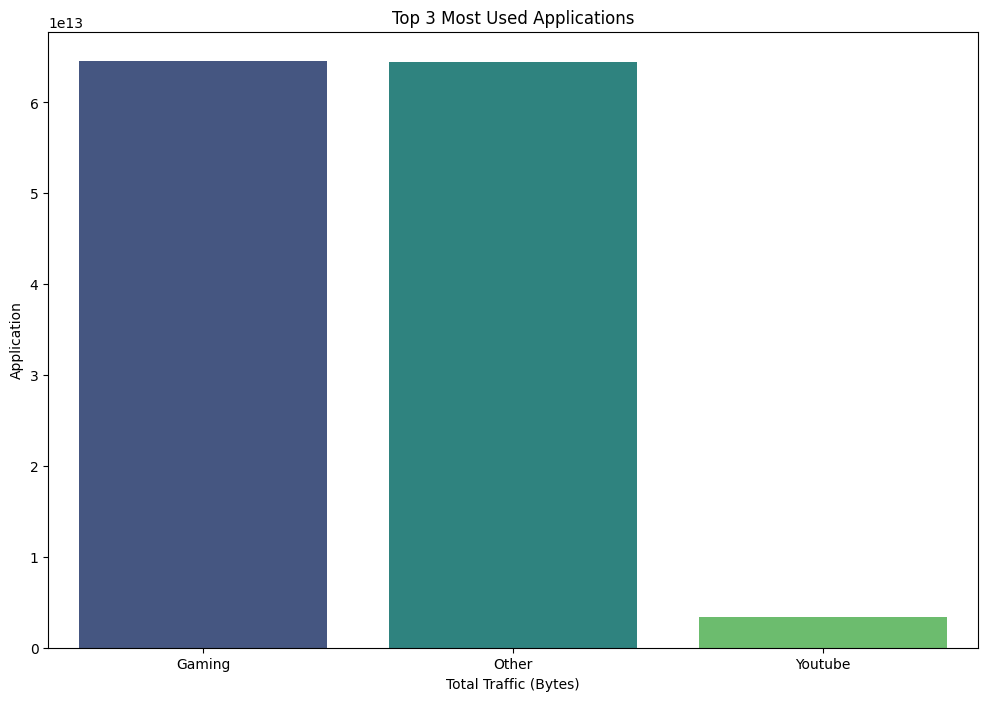

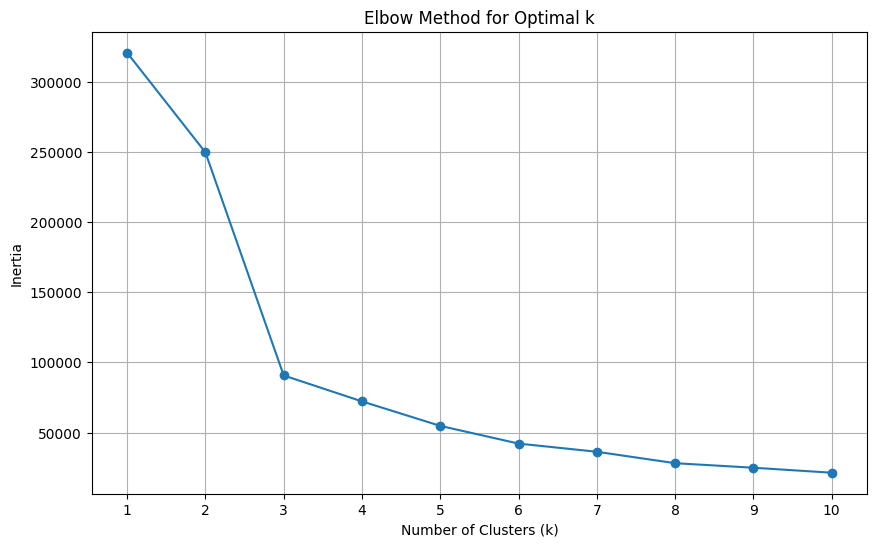

Cluster Metrics:
         session_frequency                            total_session_duration  \
                      min   max         mean     sum                    min   
cluster                                                                       
0                       1    18     1.393469  148849                 7142.0   
1                       1     6     2.324324      86                56123.0   
2                    1066  1066  1066.000000    1066             72446396.0   

                                                total_traffic                \
                max          mean           sum           min           max   
cluster                                                                       
0        18553754.0  1.461471e+05  1.561128e+10  0.000000e+00  1.775945e+10   
1          513104.0  2.041768e+05  7.554541e+06  1.808859e+10  7.302069e+10   
2        72446396.0  7.244640e+07  7.244640e+07  1.739805e+10  1.739805e+10   

                                

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sys.path.append(os.path.abspath('../scripts'))

from telecom_analysis import load_data_using_sqlalchemy

# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL using SQLAlchemy
df_user_engagement = load_data_using_sqlalchemy(query)

# Check if data loaded successfully
if df_user_engagement is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")
    sys.exit()

# Task 2.1 - Aggregate metrics per customer ID (MSISDN)
user_engagement = df_user_engagement.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',  # Session duration
    'HTTP DL (Bytes)': 'sum',  # Download bytes
    'HTTP UL (Bytes)': 'sum',  # Upload bytes
    'Bearer Id': 'count'  # Session frequency
}).rename(columns={
    'Dur. (ms)': 'total_session_duration',
    'HTTP DL (Bytes)': 'total_download',
    'HTTP UL (Bytes)': 'total_upload',
    'Bearer Id': 'session_frequency'
})

# Reset index to include 'MSISDN/Number' as a column
user_engagement = user_engagement.reset_index()

# Calculate total traffic (download + upload)
user_engagement['total_traffic'] = user_engagement['total_download'] + user_engagement['total_upload']

# Normalize the metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(user_engagement[['session_frequency', 'total_session_duration', 'total_traffic']])

# Apply K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement['cluster'] = kmeans.fit_predict(normalized_metrics)

# Assign the MSISDN/Number column to the engagement_cluster column
user_engagement['engagement_cluster'] = user_engagement['MSISDN/Number']

# Visualize the clusters
sns.pairplot(user_engagement, vars=['session_frequency', 'total_session_duration', 'total_traffic'], hue='cluster', palette='Set2')
plt.title('K-Means Clustering of User Engagement')
plt.show()


# Group by cluster and calculate summary statistics for each cluster
cluster_summary = user_engagement.groupby('cluster').agg({
    'session_frequency': ['min', 'max', 'mean', 'sum'],
    'total_session_duration': ['min', 'max', 'mean', 'sum'],
    'total_traffic': ['min', 'max', 'mean', 'sum']
})

print("Cluster Summary Statistics:\n", cluster_summary)

# Aggregate user total traffic per application
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
user_engagement_apps = pd.DataFrame()

for app in applications:
    app_dl = f'{app} DL (Bytes)'
    app_ul = f'{app} UL (Bytes)'
    
    if app_dl in df_user_engagement.columns and app_ul in df_user_engagement.columns:
        user_engagement_apps[f'{app}_total_traffic'] = df_user_engagement.groupby('MSISDN/Number')[[app_dl, app_ul]].sum().sum(axis=1)
        
        # Top 10 users per application by traffic
        top_users = user_engagement_apps[[f'{app}_total_traffic']].sort_values(f'{app}_total_traffic', ascending=False).head(10)
        print(f"\nTop 10 users by {app} traffic:")
        print(top_users)
    else:
        print(f"Columns for {app} not found in DataFrame.")

# Plot the top 3 most used applications
total_traffic = {app: user_engagement_apps[f'{app}_total_traffic'].sum() for app in applications if f'{app}_total_traffic' in user_engagement_apps.columns}
top_3_apps = sorted(total_traffic.items(), key=lambda x: x[1], reverse=True)[:3]

# Create a DataFrame for plotting
top_3_df = pd.DataFrame(top_3_apps, columns=['Application', 'Total Traffic'])

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y='Total Traffic', x='Application', data=top_3_df, palette='viridis')
plt.title('Top 3 Most Used Applications')
plt.xlabel('Total Traffic (Bytes)')
plt.ylabel('Application')
plt.show()

# Determine optimal k using the Elbow Method
inertia = []
k_range = range(1, min(len(user_engagement_apps), 11))  # Ensure k does not exceed number of samples

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the elbow plot, choose the optimal k (usually where the curve starts to flatten)
optimal_k = 3  # Replace with the value you determine from the elbow plot

# Fit k-means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_engagement['cluster'] = kmeans.fit_predict(normalized_metrics)

# Compute min, max, average, and total non-normalized metrics for each cluster
cluster_metrics = user_engagement.groupby('cluster').agg({
    'session_frequency': ['min', 'max', 'mean', 'sum'],
    'total_session_duration': ['min', 'max', 'mean', 'sum'],
    'total_traffic': ['min', 'max', 'mean', 'sum']
})

print("Cluster Metrics:\n", cluster_metrics)


Task -3

Successfully loaded the data

Top 10 TCP Retransmission Values:
5705      4.294426e+09
63404     4.291380e+09
112372    4.289877e+09
68539     4.289488e+09
81509     4.288060e+09
47410     4.275259e+09
117364    4.268432e+09
4716      4.259997e+09
136743    4.256650e+09
118936    4.254644e+09
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Bottom 10 TCP Retransmission Values:
0     0.0
1     0.0
3     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
11    0.0
12    0.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Most Frequent TCP Retransmission Values:
0    0.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64

Top 10 RTT Values:
107893    96923.0
107654    64640.0
95637     55811.0
83716     54847.0
100578    26971.0
101182    26250.0
79100     25873.0
9000      25602.0
25047     25374.0
28310     24733.0
Name: Avg RTT DL (ms), dtype: float64

Bottom 10 RTT Values:
1     0.0
6     0.0
12    0.0
14    0.0
17    0.0
18    0.0
27    0.0
33    0.0
46    0.0
61    0.0
Name: 

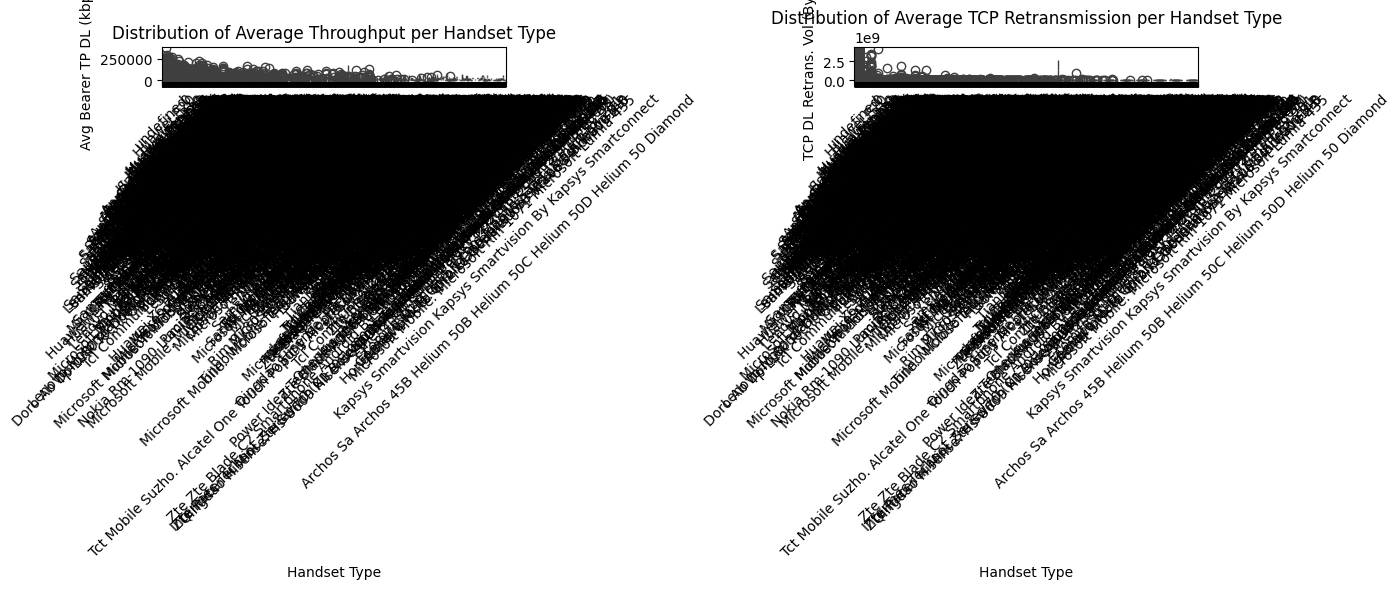

Aggregated Data by Handset Type:
                                           Handset Type  \
0                                                     0   
1                            A-Link Telecom I. Cubot A5   
2                     A-Link Telecom I. Cubot Note Plus   
3                        A-Link Telecom I. Cubot Note S   
4                          A-Link Telecom I. Cubot Nova   
...                                                 ...   
1392  Zte Zte Blade C2 Smartphone Android By Sfr Sta...   
1393                          Zyxel Communicat. Lte7460   
1394                          Zyxel Communicat. Sbg3600   
1395                    Zyxel Communicat. Zyxel Wah7706   
1396                                          undefined   

      Avg Bearer TP DL (kbps)  TCP DL Retrans. Vol (Bytes)  
0                10790.970280                 1.146738e+07  
1                23184.000000                 0.000000e+00  
2                 6527.000000                 6.023490e+05  
3             

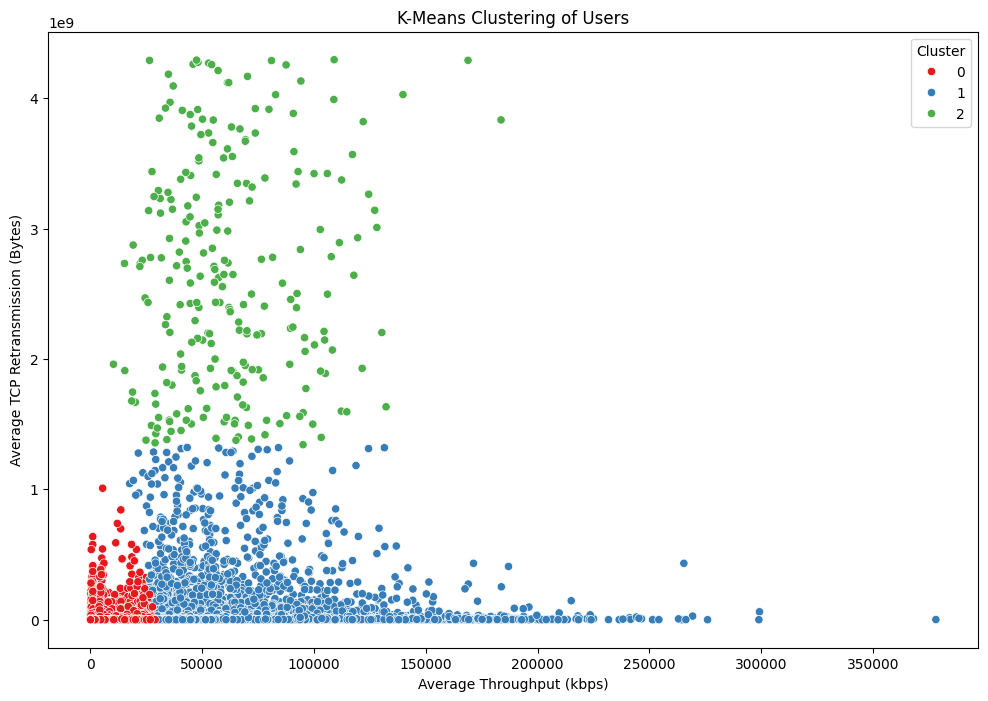

In [3]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Append the script directory to sys.path
sys.path.append(os.path.abspath('../scripts'))

from telecom_analysis import load_data_using_sqlalchemy

# Load data from PostgreSQL
query = "SELECT * FROM xdr_data;"  # Adjust as needed
df = load_data_using_sqlalchemy(query)

if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

# Task 3.1 - Aggregate per customer
def clean_and_aggregate(df):
    df.fillna({
        'TCP DL Retrans. Vol (Bytes)': df['TCP DL Retrans. Vol (Bytes)'].mean(),
        'Avg RTT DL (ms)': df['Avg RTT DL (ms)'].mean(),
        'Avg Bearer TP DL (kbps)': df['Avg Bearer TP DL (kbps)'].mean(),
        'Handset Type': df['Handset Type'].mode()[0]  # Fill missing Handset Type with mode
    }, inplace=True)
    
    # Replace infinities with NaN and fill again
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna({
        'TCP DL Retrans. Vol (Bytes)': df['TCP DL Retrans. Vol (Bytes)'].mean(),
        'Avg RTT DL (ms)': df['Avg RTT DL (ms)'].mean(),
        'Avg Bearer TP DL (kbps)': df['Avg Bearer TP DL (kbps)'].mean()
    }, inplace=True)
    
    # Aggregate data per customer
    aggregated = df.groupby('MSISDN/Number').agg({
        'TCP DL Retrans. Vol (Bytes)': 'mean',
        'Avg RTT DL (ms)': 'mean',
        'Avg Bearer TP DL (kbps)': 'mean',
        'Handset Type': 'first'  # Assuming handset type doesn't change per user
    }).reset_index()

    return aggregated

aggregated_df = clean_and_aggregate(df)

# Task 3.2 - Compute & list top, bottom, and most frequent values
def compute_statistics(df):
    # Top 10 values
    top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
    bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
    frequent_tcp = df['TCP DL Retrans. Vol (Bytes)'].mode()
    
    top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)
    bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)
    frequent_rtt = df['Avg RTT DL (ms)'].mode()
    
    top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
    bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
    frequent_throughput = df['Avg Bearer TP DL (kbps)'].mode()
    
    # Print or return statistics
    print("\nTop 10 TCP Retransmission Values:")
    print(top_10_tcp)
    
    print("\nBottom 10 TCP Retransmission Values:")
    print(bottom_10_tcp)
    
    print("\nMost Frequent TCP Retransmission Values:")
    print(frequent_tcp)
    
    print("\nTop 10 RTT Values:")
    print(top_10_rtt)
    
    print("\nBottom 10 RTT Values:")
    print(bottom_10_rtt)
    
    print("\nMost Frequent RTT Values:")
    print(frequent_rtt)
    
    print("\nTop 10 Throughput Values:")
    print(top_10_throughput)
    
    print("\nBottom 10 Throughput Values:")
    print(bottom_10_throughput)
    
    print("\nMost Frequent Throughput Values:")
    print(frequent_throughput)
    
    return {
        'top_10_tcp': top_10_tcp,
        'bottom_10_tcp': bottom_10_tcp,
        'frequ  ent_tcp': frequent_tcp,
        'top_10_rtt': top_10_rtt,
        'bottom_10_rtt': bottom_10_rtt,
        'frequent_rtt': frequent_rtt,
        'top_10_throughput': top_10_throughput,
        'bottom_10_throughput': bottom_10_throughput,
        'frequent_throughput': frequent_throughput
    }
stats_summary = compute_statistics(df)

# Task 3.3 - Distribution of average throughput and TCP retransmission
def compute_and_plot_distributions(df):
    # Aggregate data by handset type
    aggregated_data = df.groupby('Handset Type').agg({
        'Avg Bearer TP DL (kbps)': 'mean',
        'TCP DL Retrans. Vol (Bytes)': 'mean'
    }).reset_index()
    
    # Distribution of average throughput per handset type
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='Handset Type', y='Avg Bearer TP DL (kbps)', data=df)
    plt.title('Distribution of Average Throughput per Handset Type')
    plt.xticks(rotation=45)

    # Distribution of average TCP retransmission per handset type
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Handset Type', y='TCP DL Retrans. Vol (Bytes)', data=df)
    plt.title('Distribution of Average TCP Retransmission per Handset Type')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()
    
    # Print the aggregated data for interpretation
    print("Aggregated Data by Handset Type:")
    print(aggregated_data)

# Assuming df is your DataFrame
compute_and_plot_distributions(df)

# Task 3.4 - K-Means Clustering
#
def perform_kmeans_clustering(df, n_clusters=3):
    # Prepare the data for clustering
    features = df[['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)']].copy()
    features.fillna(features.mean(), inplace=True)  # Handle missing values by replacing with the mean
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Apply k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    df['Cluster'] = kmeans.fit_predict(scaled_features)
    
    # Inverse transform the cluster centers to original scale
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    cluster_centers_df = pd.DataFrame(cluster_centers, columns=['Avg Bearer TP DL (kbps)', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)'])
    
    # Display cluster centers
    print("Cluster Centers (Original Scale):")
    print(cluster_centers_df)
    
    return df

def describe_clusters(df):
    cluster_description = df.groupby('Cluster').agg({
        'Avg Bearer TP DL (kbps)': ['mean', 'std'],
        'TCP DL Retrans. Vol (Bytes)': ['mean', 'std'],
        'Avg RTT DL (ms)': ['mean', 'std'],
        'MSISDN/Number': 'count'
    }).reset_index()
    
    print("\nCluster Descriptions:")
    print(cluster_description)

    # Plot the clusters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Avg Bearer TP DL (kbps)', y='TCP DL Retrans. Vol (Bytes)', hue='Cluster', data=df, palette='Set1')
    plt.title('K-Means Clustering of Users')
    plt.xlabel('Average Throughput (kbps)')
    plt.ylabel('Average TCP Retransmission (Bytes)')
    plt.legend(title='Cluster')
    plt.show()

# Assuming df is your DataFrame
clustered_df = perform_kmeans_clustering(df)
describe_clusters(clustered_df)


Task 4 

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def compute_scores(engagement_df, aggregated_df):
    # Ensure 'MSISDN/Number' column exists in both DataFrames
    required_engagement_columns = ['MSISDN/Number', 'session_frequency', 'total_session_duration', 'total_traffic']
    required_experience_columns = ['MSISDN/Number', 'TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']
    
    for column in required_engagement_columns:
        if column not in engagement_df.columns:
            raise KeyError(f"Column '{column}' missing in engagement_df")
    
    for column in required_experience_columns:
        if column not in aggregated_df.columns:
            raise KeyError(f"Column '{column}' missing in aggregated_df")

    # Data Cleaning: Drop rows with missing values in critical columns
    engagement_df.dropna(subset=required_engagement_columns, inplace=True)
    aggregated_df.dropna(subset=required_experience_columns, inplace=True)
    
    # Normalize the data
    scaler_engagement = StandardScaler()
    engagement_features = ['session_frequency', 'total_session_duration', 'total_traffic']
    engagement_normalized = scaler_engagement.fit_transform(engagement_df[engagement_features])
    
    scaler_experience = StandardScaler()
    experience_features = ['TCP DL Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg Bearer TP DL (kbps)']
    experience_normalized = scaler_experience.fit_transform(aggregated_df[experience_features])
    
    # Perform K-Means Clustering for engagement (assuming 3 clusters)
    kmeans_engagement = KMeans(n_clusters=3, random_state=42)
    engagement_df['engagement_cluster'] = kmeans_engagement.fit_predict(engagement_normalized)
    engagement_centers = kmeans_engagement.cluster_centers_

    # Perform K-Means Clustering for experience (assuming 3 clusters)
    kmeans_experience = KMeans(n_clusters=3, random_state=42)
    aggregated_df['experience_cluster'] = kmeans_experience.fit_predict(experience_normalized)
    experience_centers = kmeans_experience.cluster_centers_

    # Identify less engaged and worst experience clusters
    less_engaged_cluster = 2
    worst_experience_cluster = 2
    
    # Calculate engagement score as Euclidean distance from the less engaged cluster
    engagement_df['engagement_score'] = engagement_df.apply(
        lambda row: euclidean(
            scaler_engagement.transform([row[engagement_features]])[0],
            engagement_centers[less_engaged_cluster]
        ), axis=1
    )

    # Calculate experience score as Euclidean distance from the worst experience cluster
    aggregated_df['experience_score'] = aggregated_df.apply(
        lambda row: euclidean(
            scaler_experience.transform([row[experience_features]])[0],
            experience_centers[worst_experience_cluster]
        ), axis=1
    )

    # Merge scores with original data to maintain MSISDN/Number for identification
    scores_df = pd.merge(
        engagement_df[['MSISDN/Number', 'engagement_score']], 
        aggregated_df[['MSISDN/Number', 'experience_score']], 
        on='MSISDN/Number', 
        how='inner'
    )

    return scores_df

def get_top_satisfied_customers(scores_df):
    # Calculate satisfaction score as the average of engagement and experience scores
    scores_df['satisfaction_score'] = scores_df[['engagement_score', 'experience_score']].mean(axis=1)
    
    # Sort by satisfaction score in descending order (higher satisfaction means lower score)
    top_10_customers = scores_df.sort_values(by='satisfaction_score').head(10)
    
    return top_10_customers

def build_regression_model(scores_df):
    # Features and target
    X = scores_df[['engagement_score', 'experience_score']]
    y = scores_df['satisfaction_score']
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict satisfaction score on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    
    return model

def kmeans_clustering_on_scores(scores_df):
    # Use engagement_score and experience_score for clustering
    kmeans = KMeans(n_clusters=2, random_state=42)
    scores_df['score_cluster'] = kmeans.fit_predict(scores_df[['engagement_score', 'experience_score']])
    
    return scores_df

def aggregate_scores_per_cluster(scores_df):
    cluster_aggregation = scores_df.groupby('score_cluster').agg({
        'satisfaction_score': 'mean',
        'experience_score': 'mean'
    }).reset_index()
    
    return cluster_aggregation

# Example usage
try:
    scores_df = compute_scores(user_engagement, aggregated_df)
    print(scores_df.head())

    top_satisfied_customers = get_top_satisfied_customers(scores_df)
    print("Top 10 Satisfied Customers:")
    print(top_satisfied_customers)

    regression_model = build_regression_model(scores_df)

    scores_with_clusters = kmeans_clustering_on_scores(scores_df)
    print(scores_with_clusters.head())

    cluster_aggregates = aggregate_scores_per_cluster(scores_with_clusters)
    print("Average Satisfaction and Experience Score per Cluster:")
    print(cluster_aggregates)

except KeyError as e:
    print(f"KeyError: {e}")
